<a href="https://colab.research.google.com/github/tomcaputo/posts/blob/master/Fraud_GBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotnine
!pip install lightgbm
!pip install optuna

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
ram_gb

54.757900288

In [ ]:
import pandas as pd
import numpy as np
import sys

In [ ]:
import time

In [ ]:
import plotnine as p
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [ ]:
sys.path.append("/content/drive/MyDrive/Colab Notebooks/Fraud")
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Colab Notebooks/Fraud/'

Mounted at /content/drive


In [ ]:
train_trans = pd.read_csv(dir + 'data/train_transaction.csv') # transactions details
train_identity = pd.read_csv(dir + 'data/train_identity.csv') # additional details about the payer
test_trans = pd.read_csv(dir + 'data/test_transaction.csv')
test_identity = pd.read_csv(dir + 'data/test_identity.csv')

In [ ]:
train = pd.merge(train_trans, train_identity, on='TransactionID', how='outer')

In [ ]:
train_trans.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

Questions to answer:

1. Target Distribution
2. Missing Data
3. Outliers
4. Categorical Variables
5. Patterns between vars and target

### Feature Overview

#### Transaction Data

- Transaction amt
- ProductCD
- card 1-6: card features
- addr 1-2: purchaser address, receiver address
  - count encode, otherwise you can historical fraud encode
- distance 1-2: distance between merchant and purchaser
- P_emaildomain: purchaser email domain
- R_emaildomain: reciever email domain
- C1-14: Counts
- D1-15: date variables
- M1-9: match (bool)

#### Identity
Only has 25% coverage on Transaction Data

- DeviceType
- DeviceInfo
- id_1 — id_38

#### Continuous Data
- Transaction amt - log transform
- C1-14: Counts - maybe Transform
- dist 1,2 - log transform
- everything else just do count

#### Categorical Data
- M1-9
  - M1 has very little information
- P_emaildomain
- R_emaildomain
- addr 1-2
  - cardinality too high for dummy. but can use historical data here as well to dummy encode
- card1-card6
  - card 4 and 6 can be dummy encoded
  - cardinality too high on other but can use historical fraud rate as a metric
- DeviceType
- DeviceInfo
- id_12 — id_38

#### Optimization Criteria: cross-entropy
#### Performance Metric: ROC
-

## EDA

### Target

In [ ]:
# Fraud Rates
train_trans['isFraud'].agg(['mean', 'sum', 'count'])

mean          0.03499
sum       20663.00000
count    590540.00000
Name: isFraud, dtype: float64

### Continuous data

In [ ]:
train_trans.select_dtypes('float64').columns

Index(['TransactionAmt', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1',
       'dist2', 'C1', 'C2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=376)

In [ ]:
train_trans.select_dtypes('int64').columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'card1'], dtype='object')

In [ ]:
train_identity.select_dtypes('float64').columns

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19',
       'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32'],
      dtype='object')

In [ ]:
train_identity.select_dtypes('int64').columns

Index(['TransactionID'], dtype='object')

In [ ]:
count_cols = train_trans.columns[train_trans.columns.str.contains('^C[0-9]')]
train_trans.groupby('isFraud')[count_cols].mean().T

isFraud,0,1
C1,13.314952,35.535740
C2,14.173283,45.509413
C3,0.005840,0.000242
C4,3.693878,15.077336
C5,5.722537,1.406717
C6,8.786377,16.923148
C7,2.517484,11.977157
C8,4.560881,21.242608
C9,4.580904,1.703964
C10,4.723526,19.493926


In [ ]:
# for col in count_cols:
#   sns.kdeplot(data=train_trans, x=col, hue='isFraud', common_norm=False)
#   plt.show()

<Axes: xlabel='TransactionAmt', ylabel='Density'>

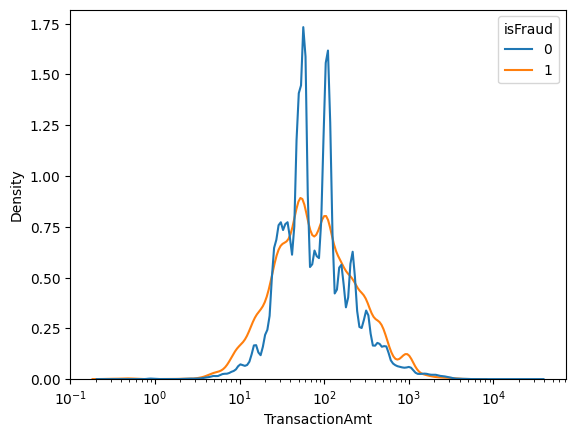

In [ ]:
sns.kdeplot(data=train_trans, x='TransactionAmt', hue='isFraud', common_norm=False, log_scale=True)

<Axes: xlabel='dist1', ylabel='Density'>

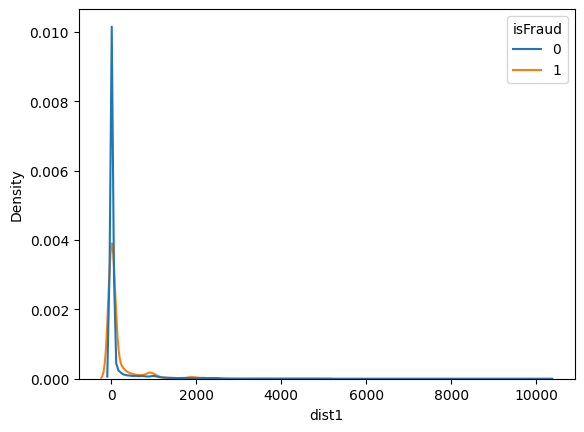

In [ ]:
sns.kdeplot(data=train_trans, x='dist1', hue='isFraud', common_norm=False)

<Axes: xlabel='dist2', ylabel='Density'>

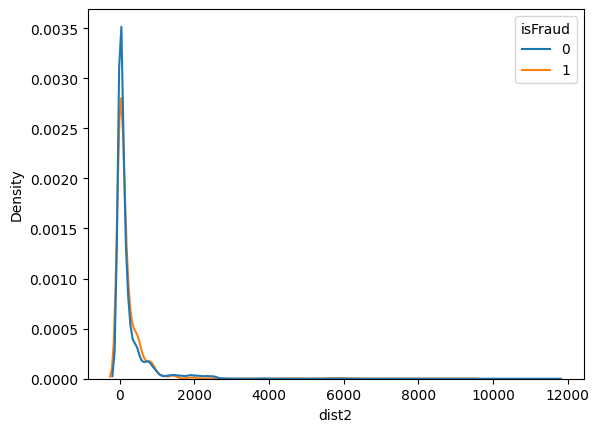

In [ ]:
sns.kdeplot(data=train_trans, x='dist2', hue='isFraud', common_norm=False)

## Categorical variables

In [ ]:
cat_columns = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2'] + train_trans.select_dtypes('object').columns.tolist()
cat_columns

['card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [ ]:
train_trans[cat_columns] = train_trans[cat_columns].astype(object)
test_trans[cat_columns] = test_trans[cat_columns].astype(object)

for col in cat_columns:
  # other
  vals_counts = train_trans.card3.value_counts()
  other_categories = vals_counts[vals_counts.values>30].index
  train_trans[col] = train_trans[col].astype(str)
  train_trans.loc[train_trans[col].isin(other_categories), col] = 'other'

  # create labels
  le = LabelEncoder()
  le.fit(list(train_trans[col].astype(str).values) + list(test_trans[col].astype(str).values))
  train_trans[col] = le.transform(list(train_trans[col].astype(str).values))
  test_trans[col] = le.transform(list(test_trans[col].astype(str).values))



In [ ]:
train_trans[cat_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   card1          590540 non-null  int64
 1   card2          590540 non-null  int64
 2   card3          590540 non-null  int64
 3   card5          590540 non-null  int64
 4   addr1          590540 non-null  int64
 5   addr2          590540 non-null  int64
 6   ProductCD      590540 non-null  int64
 7   card4          590540 non-null  int64
 8   card6          590540 non-null  int64
 9   P_emaildomain  590540 non-null  int64
 10  R_emaildomain  590540 non-null  int64
 11  M1             590540 non-null  int64
 12  M2             590540 non-null  int64
 13  M3             590540 non-null  int64
 14  M4             590540 non-null  int64
 15  M5             590540 non-null  int64
 16  M6             590540 non-null  int64
 17  M7             590540 non-null  int64
 18  M8             590540 no

## Transform Continuous variables

In [ ]:
cont_columns = pd.Series(train_trans.select_dtypes('float').columns.tolist())
cont_columns = cont_columns[~cont_columns.str.contains('V[0-9]')]
cont_columns = cont_columns[~cont_columns.isin(cat_columns)]
cont_columns

0     TransactionAmt
1              dist1
2              dist2
3                 C1
4                 C2
5                 C3
6                 C4
7                 C5
8                 C6
9                 C7
10                C8
11                C9
12               C10
13               C11
14               C12
15               C13
16               C14
17                D1
18                D2
19                D3
20                D4
21                D5
22                D6
23                D7
24                D8
25                D9
26               D10
27               D11
28               D12
29               D13
30               D14
31               D15
dtype: object

In [ ]:
## log trans
log_vars = ['dist1', 'dist2', 'TransactionAmt']

In [ ]:
for col in log_vars:
  train_trans['log_' + col] = np.log(train_trans[col] + .001)
  test_trans['log_' + col] = np.log(test_trans[col] + .001)

## Prepare dating for modelling

### Missing values:
- [airbnb knn imputation method](https://medium.com/airbnb-engineering/overcoming-missing-values-in-a-random-forest-classifier-7b1fc1fc03ba)
- XGBoost learns which way to split missing data at each node, though sometimes we can beath this method by considering all the data when imputing

In [ ]:
all_cols = cont_columns.tolist() + cat_columns
[all_cols.remove(x) for x in log_vars]

[None, None, None]

In [ ]:
all_cols = all_cols + ['log_' + x for x in log_vars]

In [ ]:
all_cols

['C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'log_dist1',
 'log_dist2',
 'log_TransactionAmt']

In [ ]:
# outlier detection
train_trans[all_cols].agg(['max', 'min']).T

,max,min
C1,4685.000000,0.000000
C2,5691.000000,0.000000
C3,26.000000,0.000000
C4,2253.000000,0.000000
C5,349.000000,0.000000
C6,2253.000000,0.000000
C7,2255.000000,0.000000
C8,3331.000000,0.000000
C9,210.000000,0.000000
C10,3257.000000,0.000000


## LightGBM

In [ ]:
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [ ]:
num_features = train_trans[cat_columns].nunique().sum() + len(cont_columns)

In [ ]:
start_params = {'num_leaves': int(np.sqrt(num_features)), # sqrt(features)
          'min_child_weight': 0.001,
          'feature_fraction': .5,
          'min_data_in_leaf': 50,
          'objective': 'binary',
          'max_depth': 6, # usually 3-10
          'learning_rate': 0.01, # usually .01-.02
          "bagging_seed": 123,
          "metric": 'auc',
          'reg_alpha': 0,
          'reg_lambda': 0,
          'random_state': 123,
         }

start_params = {
         }

In [ ]:
dtrain.num_feature()

52

In [ ]:
train_trans[all_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 52 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   C1                  590540 non-null  float64
 1   C2                  590540 non-null  float64
 2   C3                  590540 non-null  float64
 3   C4                  590540 non-null  float64
 4   C5                  590540 non-null  float64
 5   C6                  590540 non-null  float64
 6   C7                  590540 non-null  float64
 7   C8                  590540 non-null  float64
 8   C9                  590540 non-null  float64
 9   C10                 590540 non-null  float64
 10  C11                 590540 non-null  float64
 11  C12                 590540 non-null  float64
 12  C13                 590540 non-null  float64
 13  C14                 590540 non-null  float64
 14  D1                  589271 non-null  float64
 15  D2                  309743 non-nul

In [ ]:
nfolds = 5
folds = KFold(n_splits=nfolds) # lets do time based split

X = train_trans[all_cols]
y = train_trans['isFraud']

splits = folds.split(X, y)
cols = all_cols
y_oof = np.zeros(X.shape[0])

score = 0

for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[cols].iloc[train_index], X[cols].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    trainer = lgb.train(start_params, dtrain, 500,
                    valid_sets = [dtrain, dvalid])


    y_pred_valid = trainer.predict(X_valid)
    y_oof[valid_index] = y_pred_valid

    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")

    score += roc_auc_score(y_valid, y_pred_valid) / nfolds
    #y_preds += trainer.predict(X_test) / NFOLDS

    # del X_train, X_valid, y_train, y_valid
    # gc.collect()

print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7800
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 52
[LightGBM] [Info] Start training from score 0.037756
Fold 1 | AUC: 0.8853684975307726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8569
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 52
[LightGBM] [Info] Start training from score 0.033721
Fold 2 | AUC: 0.9045571396615878
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.332274 seconds.
You can set `for

## Optimization

In [ ]:
import optuna

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
space = {'num_leaves': hp.choice("num_leaves", list(range(20, 100, 20))),
          'feature_fraction': hp.uniform('feature_feaction', .3, .5),
          'min_data_in_leaf': 50,
          'objective': 'binary',
          'max_depth': hp.uniform('max_depth', 3, 10), # usually 3-10
          'learning_rate': hp.uniform('learning_rate', 0.01, .2), # usually .01-.2
          "metric": 'auc',
          'reg_alpha': hp.uniform('reg_alpha', 0.01, 0.4),
          'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.4),
         }

In [ ]:
def objective(params):
  time1 = time.time()
  nfolds = 3
  folds = KFold(n_splits=nfolds) # lets do time based split

  X = train_trans[all_cols]
  y = train_trans['isFraud']

  splits = folds.split(X, y)
  cols = all_cols
  y_oof = np.zeros(X.shape[0])

  score = 0

  for fold_n, (train_index, valid_index) in enumerate(splits):
      X_train, X_valid = X[cols].iloc[train_index], X[cols].iloc[valid_index]
      y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

      dtrain = lgb.Dataset(X_train, label=y_train)
      dvalid = lgb.Dataset(X_valid, label=y_valid)

      trainer = lgb.train(start_params, dtrain, 500,
                      valid_sets = [dtrain, dvalid])


      y_pred_valid = trainer.predict(X_valid)
      y_oof[valid_index] = y_pred_valid

      print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")

      score += roc_auc_score(y_valid, y_pred_valid)
  return score

In [ ]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7794
[LightGBM] [Info] Number of data points in the train set: 393693, number of used features: 52
[LightGBM] [Info] Start training from score 0.037664
Fold 1 | AUC: 0.8838755237045184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.285484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8576
[LightGBM] [Info] Number of data points in the train set: 393693, number of used features: 52
[LightGBM] [Info] Start training from score 0.032812
Fold 2 | AUC: 0.8901898244237474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029722 seconds.
You can set `for

In [ ]:
best_params = space_eval(space, best)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.0 MB/s eta 0:00:00


In [ ]:
train_trans[cont_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 32 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionAmt  590540 non-null  float64
 1   dist1           238269 non-null  float64
 2   dist2           37627 non-null   float64
 3   C1              590540 non-null  float64
 4   C2              590540 non-null  float64
 5   C3              590540 non-null  float64
 6   C4              590540 non-null  float64
 7   C5              590540 non-null  float64
 8   C6              590540 non-null  float64
 9   C7              590540 non-null  float64
 10  C8              590540 non-null  float64
 11  C9              590540 non-null  float64
 12  C10             590540 non-null  float64
 13  C11             590540 non-null  float64
 14  C12             590540 non-null  float64
 15  C13             590540 non-null  float64
 16  C14             590540 non-null  float64
 17  D1        

In [ ]:
%

0     TransactionAmt
1              dist1
2              dist2
3                 C1
4                 C2
5                 C3
6                 C4
7                 C5
8                 C6
9                 C7
10                C8
11                C9
12               C10
13               C11
14               C12
15               C13
16               C14
17                D1
18                D2
19                D3
20                D4
21                D5
22                D6
23                D7
24                D8
25                D9
26               D10
27               D11
28               D12
29               D13
30               D14
31               D15
dtype: object

In [ ]:
cat_columns

['card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

<ipython-input-30-7c42467c6b8c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

<ipython-input-30-7c42467c6b8c>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

<ipython-input-30-7c42467c6b8c>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either

Text(0, 0.5, 'Count')

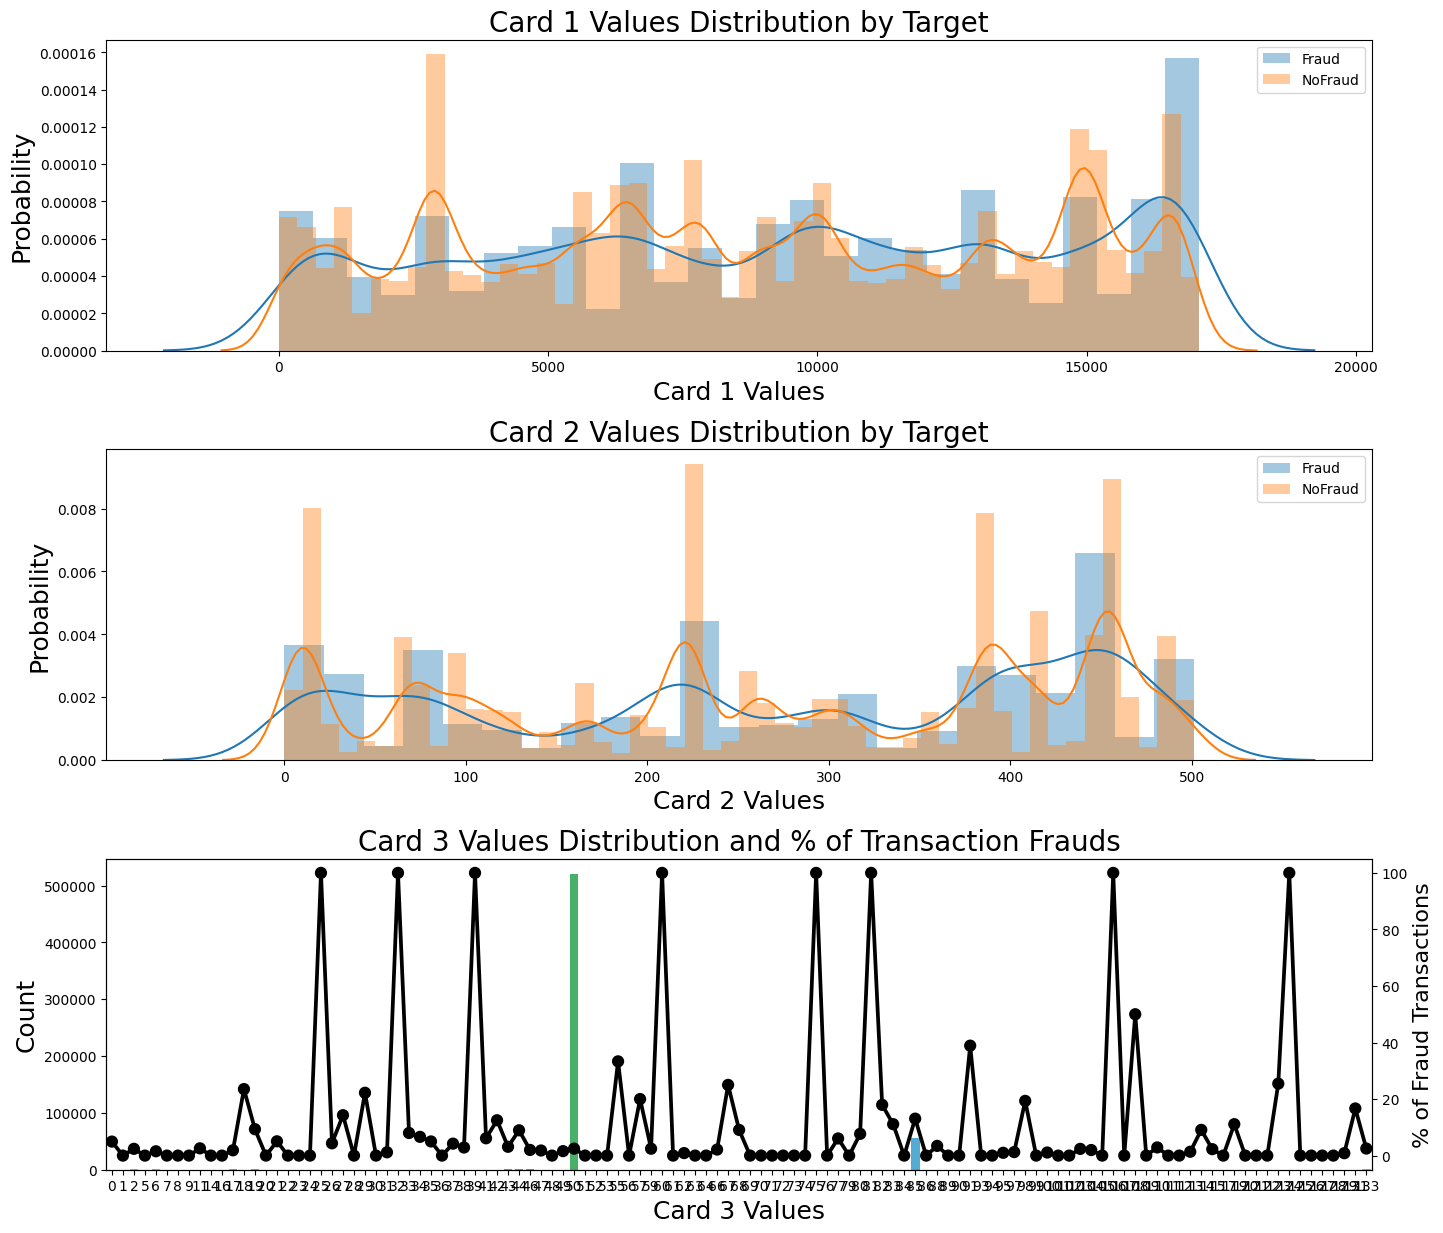

In [ ]:
tmp = pd.crosstab(train_trans['card3'], train_trans['isFraud'], normalize='index') * 100
tmp.reset_index(inplace=True)
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
plt.figure(figsize=(14, 16))

# each plot is created in a plot // CONTINUOUS
plt.subplot(411)
g = sns.distplot(train_trans[train_trans['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(train_trans[train_trans['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(train_trans[train_trans['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(train_trans[train_trans['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)
plt.tight_layout()


plt.subplot(413) #
g2 = sns.countplot(x='card3', data=train_trans, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp,
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)

In [ ]:
matching_cols = train_trans.columns[train_trans.columns.str.contains('^M[1-9]')].tolist()
card_cols = train_trans.columns[train_trans.columns.str.contains('^card[1-9]')].tolist()
# trans_cat_cols = ['P_emaildomain', 'R_emaildomain', 'addr1', 'addr2'] + matching_cols + card_cols
# identity_cols = ['DeviceType', 'DeviceInfo'] + ['id_{}'.format(i) for i in range(12, 38+1)]

categorical_vars =

SyntaxError: ignored